#  PROGETTO FINALE IDS 


Utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024, per provare a predire le ultime 5 giornate che vanno dalla 33° giornata alla 38°giornata.
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata).

Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

1: vittoria della squadra di casa

X: pareggio

2: vittoria della squadra in trasferta

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn

### PASSO 1: INTEGRIAMO IL FILE DELLE PARTITE E LO PULIAMO

Importiamo la tabella Serie A_matches_23_24.csv, che contiene i risultati di tutte le partite del campionato, e visualizziamo le prime righe con .head().

In [20]:
matches = pd.read_csv('dataset/Serie A_matches_23_24.csv')
matches.head()


,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,0_1,Full-Time,NaN,NaN,NaN,NaN
1,1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,1_3,Full-Time,NaN,NaN,NaN,NaN
2,1,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,1_4,Full-Time,NaN,NaN,NaN,NaN
3,1,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,2_0,Full-Time,NaN,NaN,NaN,NaN
4,1,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,2_2,Full-Time,NaN,NaN,NaN,NaN


Come si può notare dalla tabella:
- Le colonne 'Unnamed: xx' non contengono dati informativi.

- 'Round Name' 'Round' contengono informazioni ridondanti.

- "UTC Time", "Finished", "Started", "Cancelled", "Awarded", "Match Status" sono colonne inutili per il nostro modello, le eliminiamo

In [21]:
drop_columns = ['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14','Round Name', "UTC Time", "Finished", "Started", "Cancelled", "Awarded", "Match Status"]
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Score
0,1,Empoli,Hellas Verona,0_1
1,1,Frosinone,Napoli,1_3
2,1,Genoa,Fiorentina,1_4
3,1,Inter,Monza,2_0
4,1,Roma,Salernitana,2_2


In [22]:
#controlliamo se ci sono valori nulli
matches.isnull().sum()

Round        0
Home Team    0
Away Team    0
Score        0
dtype: int64

Ci siamo accorti che la colonna Score che indica il risultato finale della partita, presenta il punteggio in un'unica stringa.

Procediamo quindi a suddividere e a convertire ad intero questi valori in due nuove colonne: 
- Score_casa 
- Score_trasferta.



In [23]:
matches[['Score_casa', 'Score_trasferta']] = matches['Score'].str.split('_', expand=True).astype(int)
matches.drop('Score', axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta
0,1,Empoli,Hellas Verona,0,1
1,1,Frosinone,Napoli,1,3
2,1,Genoa,Fiorentina,1,4
3,1,Inter,Monza,2,0
4,1,Roma,Salernitana,2,2


Creiamo una nuova colonna Risultato, calcolata come segue:

Se Score_casa > Score_trasferta, allora Risultato = 1 (vittoria in casa)

Se Score_casa < Score_trasferta, allora Risultato = 2 (vittoria in trasferta)

Se i due valori sono uguali, allora Risultato = X (pareggio)

In [24]:
matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'

matches.head()



,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Empoli,Hellas Verona,0,1,2
1,1,Frosinone,Napoli,1,3,2
2,1,Genoa,Fiorentina,1,4,2
3,1,Inter,Monza,2,0,1
4,1,Roma,Salernitana,2,2,X


Abbiamo così pulito il dataset, creato nuove colonne ed eliminato quelle superflue, in modo da avere ben chiari i dati su cui lavoreremo.

### PASSO 2: VISUALIZZAZIONE GRAFICA DEL RENDIMENTO CASA VS TRASFERTA 

Analizzare il rendimento delle squadre tra partite in casa e in trasferta è fondamentale per comprendere il comportamento delle squadre in diversi contesti ambientali.

Nel calcio, il fattore campo può influenzare in modo significativo i risultati: il supporto del pubblico, la familiarità con il campo e minori spostamenti possono contribuire a un rendimento superiore in casa rispetto alle partite fuori casa.

Per questo motivo, confrontiamo i punti ottenuti da ciascuna squadra in casa e in trasferta. Calcoliamo quindi:
- `points_home`: 3 punti per ogni vittoria in casa + 1 punto per ogni pareggio in casa
- `points_away`: 3 punti per ogni vittoria fuori casa + 1 punto per ogni pareggio fuori casa
- `points_diff`: la differenza tra rendimento casalingo e in trasferta

Successivamente, ordiniamo le squadre in base alla differenza (`points_diff`) e visualizziamo il tutto con un grafico a barre comparativo.


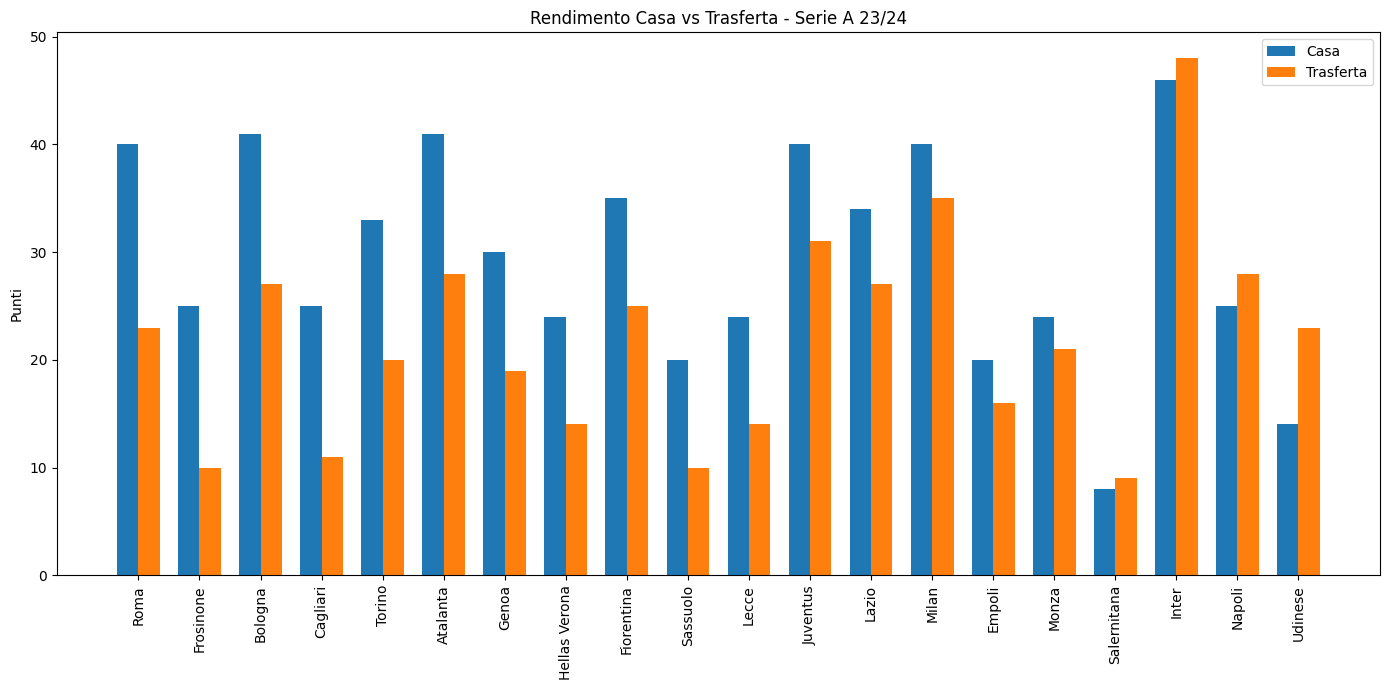

,name,points_home,points_away,points_diff
4,Roma,40,23,17
12,Frosinone,25,10,15
2,Bologna,41,27,14
11,Cagliari,25,11,14
8,Torino,33,20,13
1,Atalanta,41,28,13
9,Genoa,30,19,11
14,Hellas Verona,24,14,10
6,Fiorentina,35,25,10
17,Sassuolo,20,10,10


In [25]:
# Unione dei dati per confronto
home = pd.read_csv('dataset/Serie A_table_home_2023_24.csv')
away = pd.read_csv('dataset/Serie A_table_away_2023_24.csv')

home_vs_away = pd.merge(
    home[['idx' ,'name','played','wins','draws','losses','scoresStr','goalConDiff','pts']],
    away[['idx' ,'name','played','wins','draws','losses','scoresStr','goalConDiff','pts']],
    on='name',
    suffixes=('_home', '_away')
)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['wins_home'] * 3 + home_vs_away['draws_home']
home_vs_away['points_away'] = home_vs_away['wins_away'] * 3 + home_vs_away['draws_away']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]


Dal grafico possiamo osservare alcune tendenze molto interessanti:

- Alcune squadre mostrano un netto **vantaggio nelle partite casalinghe**, ottenendo molti più punti in casa rispetto alla trasferta. Ad esempio, squadre con >40 punti in casa come la **Roma** o il **Bologna** e l'**Atalanta** hanno una forte dipendenza dal fattore campo. Questo potrebbe essere dovuto alla spinta del pubblico, alla familiarità con il terreno di gioco o a una mentalità più offensiva quando si gioca davanti ai propri tifosi.

- Al contrario, squadre con >40 punti in casa come l’**Inter** il **Milan** e la **Juventus** dimostrano una maggiore **continuità di rendimento**, con punteggi simili sia in casa che in trasferta. Questo è tipico delle squadre di vertice, capaci di adattarsi tatticamente in contesti diversi e mantenere una buona solidità ovunque giochino.

- Le squadre che ottengono **più punti in trasferta che in casa** (se presenti) rappresentano casi particolari, spesso associati a un gioco basato sul contropiede o su una maggiore efficacia difensiva quando non hanno il pallino del gioco.

Queste osservazioni sono fondamentali per costruire un modello predittivo più realistico, in quanto evidenziano che il rendimento non è omogeneo tra casa e trasferta. Tenere conto di questa variabile può migliorare significativamente l'accuratezza delle previsioni.


## Analisi offensiva e difensiva delle squadre

Esaminiamo il rendimento offensivo e difensivo delle squadre. Questo ci può aiutare a capire quali squadre segnano di più e quali subiscono meno gol, fattori determinanti per predire i risultati.

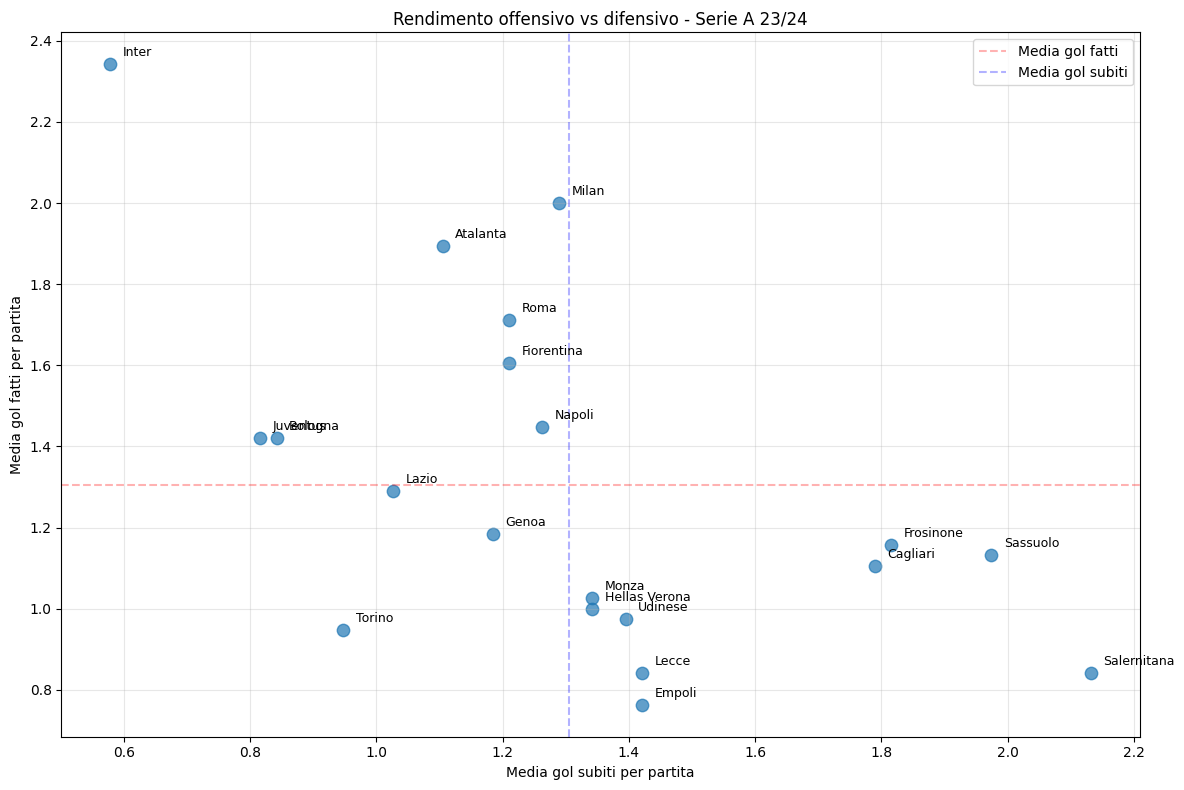

In [26]:
home_vs_away[['GolFatti_casa', 'GolSubiti_casa']] = home_vs_away['scoresStr_home'].str.split('[:|-]', expand=True).astype(int)
home_vs_away[['GolFatti_trasferta', 'GolSubiti_trasferta']] = home_vs_away['scoresStr_away'].str.split('[:|-]', expand=True).astype(int)

home_vs_away['Media_gol_fatti'] = (home_vs_away['GolFatti_casa'] + home_vs_away['GolFatti_trasferta']) / (home_vs_away['played_home'] + home_vs_away['played_away'])
home_vs_away['Media_gol_subiti'] = (home_vs_away['GolSubiti_casa'] + home_vs_away['GolSubiti_trasferta']) / (home_vs_away['played_home'] + home_vs_away['played_away'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(home_vs_away['Media_gol_subiti'], home_vs_away['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in home_vs_away.iterrows():
    plt.annotate(row['name'], # Use the 'name' column for team names
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=home_vs_away['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=home_vs_away['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere meglio le probabilità di base di ciascun esito.

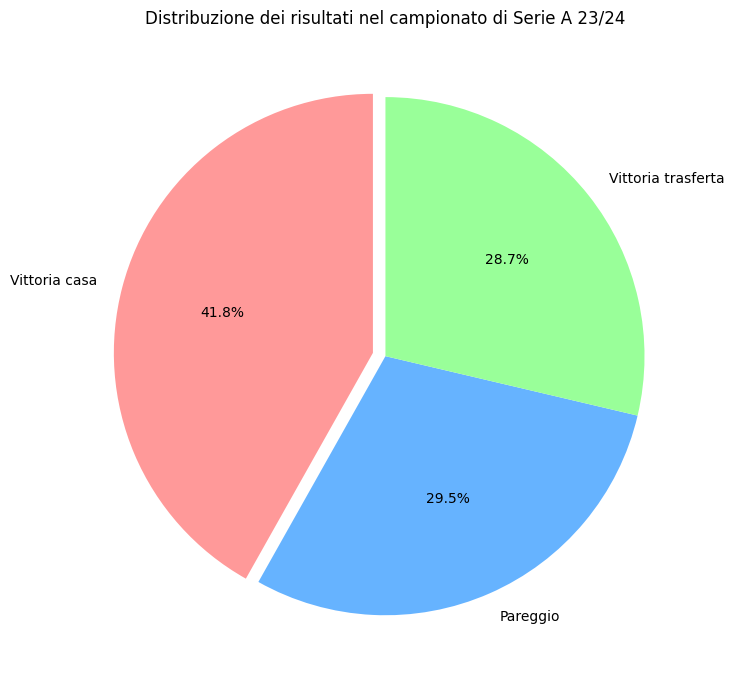

Vittorie in casa: 159 (41.8%)
Pareggi: 112 (29.5%)
Vittorie in trasferta: 109 (28.7%)


In [27]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Classifica reale vs Expected Goals (xG)

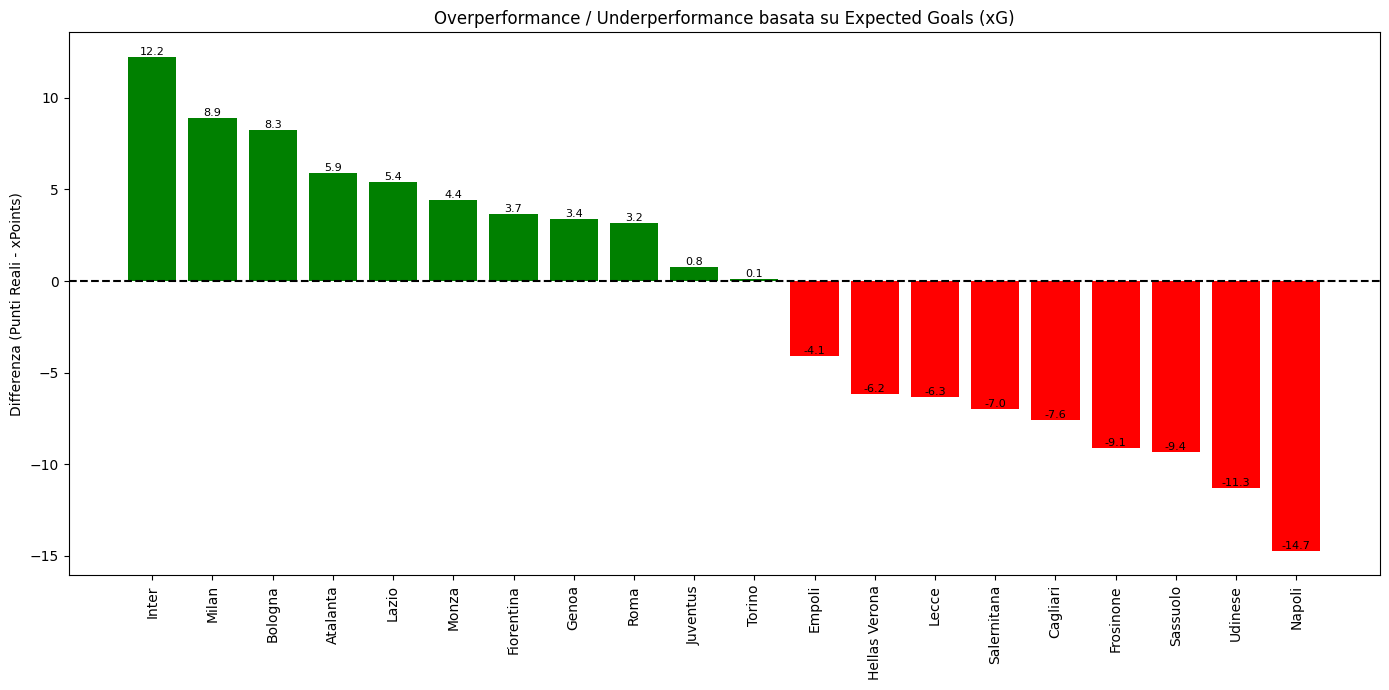

             name  pts    xPoints       diff
0           Inter   94  81.770904  12.229096
1           Milan   75  66.109611   8.890389
4         Bologna   68  59.749251   8.250749
3        Atalanta   69  63.097566   5.902434
6           Lazio   61  55.577535   5.422465
11          Monza   45  40.556915   4.443085
7      Fiorentina   60  56.317305   3.682695
10          Genoa   49  45.626036   3.373964
5            Roma   63  59.841562   3.158438
2        Juventus   71  70.235403   0.764597
8          Torino   53  52.872503   0.127497
16         Empoli   36  40.066971  -4.066971
12  Hellas Verona   38  44.156123  -6.156123
13          Lecce   38  44.322273  -6.322273
19    Salernitana   17  23.963821  -6.963821
15       Cagliari   36  43.601563  -7.601563
17      Frosinone   35  44.089054  -9.089054
18       Sassuolo   30  39.352546  -9.352546
14        Udinese   37  48.323760 -11.323760
9          Napoli   53  67.713537 -14.713537


In [28]:
sa = pd.read_csv('dataset/Serie A_table_2023_24.csv')
xg = pd.read_csv('dataset/Serie A_table_xg_2023_24.csv')
merged = pd.merge(sa[['name', 'pts']], xg[['name', 'xPoints']], on='name')
# Calcolo differenza punti reali - punti attesi
merged['diff'] = merged['pts'] - merged['xPoints']

# Ordinamento per chi over/underperforma di più
merged_sorted = merged.sort_values('diff', ascending=False)
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_sorted['name'], merged_sorted['diff'], color=['green' if x > 0 else 'red' for x in merged_sorted['diff']])

plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('Differenza (Punti Reali - xPoints)')
plt.title('Overperformance / Underperformance basata su Expected Goals (xG)')

# Aggiungiamo le etichette sulle barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,1), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Mostriamo anche la tabella per riferimento
print(merged_sorted[['name', 'pts', 'xPoints', 'diff']])

Da come possiamo notare dal grafico:

Inter, Milan, Bologna → Squadre molto efficienti, probabilmente hanno avuto anche un po’ di fortuna/cinismo.
Napoli, Udinese, Sassuolo → Squadre sfortunate o poco concrete davanti alla porta.

In particolare, il Napoli ha ben 14 punti in meno rispetto a quanto ci si aspetterebbe dagli xG! Questo suggerisce che sta creando buone occasioni, ma non riesce a concretizzarle.

DA FARE IPOTESI

PREDIZIONE DELLE ULTIME 5 GIORNATE

train per le partite che vanno dalle 1 alla 32 e test per quelle dalla 33 alla 38
Così potremo lavorare solo sui matche che ci interessano per addestrare il modello e predire le ultime 5 giornate.

In [29]:
# Iniziamo isolando i dati di addestramento (giornate 1-32) e di test (giornate 33-38)
train_df = matches[matches["Round"] <= 32].copy()
test_df = matches[matches["Round"] >= 33].copy()

Costruiamo ora i dati in tempo reale.
Per ogni squadra e per ogni giornata andremo ad aggiornare le statistiche in tempo reale.
avremo così una tabella che si aggiorna ad ogni giornata con le colonne interessate aggiornate: 
- Home_GoalFatti  
- Home_GoalSubiti
- Home_Pts	 
- Away_GoalFatti  
- Away_GoalSubiti 
- Away_Pts

In [30]:
# Lista di tutte le squadre
teams = pd.unique(train_df[['Home Team', 'Away Team']].values.ravel())

# Iniziamo costruendo un dizionario con le statistiche iniziali per ogni squadra
team_stats = {team: {
    'partite_giocate': 0,
    'gol_fatti': 0,
    'gol_subiti': 0,
    'vittorie': 0,
    'pareggi': 0,
    'sconfitte': 0,
    'punti': 0
} for team in teams}

# Creeremo una lista per memorizzare le feature per ogni riga
match_features = []

# Ordiniamo per giornata per mantenere la cronologia
train_df = train_df.sort_values(by="Round")

# Cicliamo sulle partite per generare statistiche aggiornate PRIMA di ogni match
for idx, row in train_df.iterrows():
    home = row['Home Team']
    away = row['Away Team']
    gh = row['Score_casa']
    ga = row['Score_trasferta']
    result = row['Risultato']
    
    # Recuperiamo le statistiche PRIMA della partita
    home_stats = team_stats[home].copy()
    away_stats = team_stats[away].copy()
    
    # Salviamo le feature
    match_features.append({
        'Round': row['Round'],
        'Home Team': home,
        'Away Team': away,
        'Home_GoalFatti': home_stats['gol_fatti'],
        'Home_GoalSubiti': home_stats['gol_subiti'],
        'Home_Pts': home_stats['punti'],
        'Away_GoalFatti': away_stats['gol_fatti'],
        'Away_GoalSubiti': away_stats['gol_subiti'],
        'Away_Pts': away_stats['punti'],
        'Risultato': result
    })
    
    # Dopo aver salvato, aggiorniamo le statistiche
    team_stats[home]['partite_giocate'] += 1
    team_stats[away]['partite_giocate'] += 1
    team_stats[home]['gol_fatti'] += gh
    team_stats[home]['gol_subiti'] += ga
    team_stats[away]['gol_fatti'] += ga
    team_stats[away]['gol_subiti'] += gh
    
    if result == '1':
        team_stats[home]['vittorie'] += 1
        team_stats[home]['punti'] += 3
        team_stats[away]['sconfitte'] += 1
    elif result == '2':
        team_stats[away]['vittorie'] += 1
        team_stats[away]['punti'] += 3
        team_stats[home]['sconfitte'] += 1
    elif result == 'X':
        team_stats[home]['pareggi'] += 1
        team_stats[away]['pareggi'] += 1
        team_stats[home]['punti'] += 1
        team_stats[away]['punti'] += 1

# Convertiamo la lista di dizionari in un DataFrame
train_features_df = pd.DataFrame(match_features)
train_features_df.head(10)


,Round,Home Team,Away Team,Home_GoalFatti,Home_GoalSubiti,Home_Pts,Away_GoalFatti,Away_GoalSubiti,Away_Pts,Risultato
0,1,Empoli,Hellas Verona,0,0,0,0,0,0,2
1,1,Frosinone,Napoli,0,0,0,0,0,0,2
2,1,Genoa,Fiorentina,0,0,0,0,0,0,2
3,1,Inter,Monza,0,0,0,0,0,0,1
4,1,Roma,Salernitana,0,0,0,0,0,0,X
5,1,Sassuolo,Atalanta,0,0,0,0,0,0,2
6,1,Lecce,Lazio,0,0,0,0,0,0,1
7,1,Udinese,Juventus,0,0,0,0,0,0,2
8,1,Torino,Cagliari,0,0,0,0,0,0,X
9,1,Bologna,Milan,0,0,0,0,0,0,2


In [31]:
train_features_df.tail(10)

,Round,Home Team,Away Team,Home_GoalFatti,Home_GoalSubiti,Home_Pts,Away_GoalFatti,Away_GoalSubiti,Away_Pts,Risultato
310,32,Lazio,Salernitana,37,34,46,25,64,15,1
311,32,Lecce,Empoli,26,48,29,25,47,28,1
312,32,Torino,Juventus,31,29,44,45,24,62,X
313,32,Bologna,Monza,45,25,58,34,41,42,X
314,32,Napoli,Frosinone,48,38,48,38,61,26,X
315,32,Sassuolo,Milan,36,59,25,60,34,68,X
316,32,Inter,Cagliari,75,15,82,32,52,30,X
317,32,Fiorentina,Genoa,45,37,46,34,38,38,X
318,32,Atalanta,Hellas Verona,57,37,50,28,42,27,X
319,32,Udinese,Roma,30,47,28,56,35,55,2


## Modello di Predizione basato su Media Gol

Creiamo un modello semplice che predice i risultati delle ultime 5 giornate (dalla giornata 33 alla 38) basandosi sulla media dei gol segnati e subiti dalle squadre sia in casa che in trasferta.

In [32]:
def predict_match_results(matches, threshold_home,threshold_away):
    """
    Predice i risultati delle partite dalla giornata 33 in poi utilizzando
    le medie dei gol fatti e subiti da ciascuna squadra.
    
    Args:
        matches: DataFrame con tutti i dati delle partite
        threshold: Parametro che determina la differenza di gol necessaria per predire una vittoria
    
    Returns:
        DataFrame con le predizioni e i risultati reali
    """
    # Divisione dei dati in training (giornate 1-32) e test (giornate 33-38)
    train_df = matches[matches["Round"] < 33].copy()
    test_df = matches[matches["Round"] >= 33].copy()
    
    # Calcolo delle statistiche per ogni squadra
    teams = pd.unique(matches[['Home Team', 'Away Team']].values.ravel())
    team_stats = {}
    
    for team in teams:
        # Filtra le partite in casa e in trasferta per questa squadra
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola le medie dei gol (evita divisione per zero)
        avg_home_scored = home_matches['Score_casa'].mean() if len(home_matches) > 0 else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if len(home_matches) > 0 else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if len(away_matches) > 0 else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if len(away_matches) > 0 else 0
        
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded
        }
    
    # Effettua le predizioni
    predictions = []
    
    for _, match in test_df.iterrows():
        home_team = match['Home Team']
        away_team = match['Away Team']
        
        # Calcolo dei gol attesi
        home_exp_goals = (team_stats[home_team]['avg_home_scored'] + 
                          team_stats[away_team]['avg_away_conceded']) / 2
        away_exp_goals = (team_stats[away_team]['avg_away_scored'] + 
                          team_stats[home_team]['avg_home_conceded']) / 2
        
        # Predici il risultato basandosi sulla differenza di gol e sul threshold
        goal_diff = home_exp_goals - away_exp_goals
        
        if goal_diff >  threshold_home:
            prediction = '1'  # Vittoria casa
        elif goal_diff < -threshold_away:
            prediction = '2'  # Vittoria trasferta
        else:
            prediction = 'X'  # Pareggio
        
        predictions.append(prediction)
    
    # Aggiungi le predizioni al DataFrame dei risultati
    test_df['Prediction'] = predictions
    
    # Calcola l'accuratezza
    accuracy = (test_df['Risultato'] == test_df['Prediction']).mean()
    print(f"Accuratezza della predizione: {accuracy:.2f}")
    
    return test_df, team_stats, accuracy

In [33]:
# Troviamo i threshold ottimali con ricerca a griglia
best_acc = 0
best_threshold_home = 0.1
best_threshold_away = 0.0

# Definisci il range di valori da testare per entrambi i threshold
threshold_range = np.arange(0.1, 1.0, 0.01)

# Salva i risultati per graficarli
results = []

# Nested loop per testare tutte le combinazioni
for th_home in threshold_range:
    for th_away in threshold_range:
        _, _, acc = predict_match_results(matches, threshold_home=th_home, threshold_away=th_away)
        results.append((th_home, th_away, acc))
        print(f"Threshold casa: {th_home:.2f}, Threshold trasferta: {th_away:.2f}, Accuratezza: {acc:.2f}")
        
        if acc > best_acc:
            best_acc = acc
            best_threshold_home = th_home
            best_threshold_away = th_away

print(f"\nMiglior combinazione: Threshold casa = {best_threshold_home:.2f}, "
      f"Threshold trasferta = {best_threshold_away:.2f}, Accuratezza: {best_acc:.2f}")

# Visualizziamo i risultati finali con i threshold ottimali
final_predictions, _, _ = predict_match_results(matches, threshold_home=best_threshold_home, 
                                               threshold_away=best_threshold_away)

Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.10, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.11, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.12, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.13, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.14, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.15, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.16, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.17, Accuratezza: 0.42
Accuratezza della predizione: 0.42
Threshold casa: 0.10, Threshold trasferta: 0.18, Accuratezza: 0.42
Accuratezza della predizione: 0.40
Threshold casa: 0.10, Threshold trasferta: 0.19

In [34]:
# Eseguire la predizione con il threshold ottimale
predictions_df, team_stats, _ = predict_match_results(matches, threshold_home=best_threshold_home, 
                                               threshold_away=best_threshold_away)

# Visualizziamo il riassunto dei risultati per giornata
results_by_round = predictions_df.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())
print("Accuratezza per giornata:")
print(results_by_round)

# Visualizziamo i risultati per l'ultima giornata
round_num = 38
round_df = predictions_df[predictions_df['Round'] == round_num]
print(f"\n=== Giornata {round_num} ===")
print(round_df[['Home Team', 'Away Team', 'Score_casa', 'Score_trasferta', 'Risultato', 'Prediction']])

Accuratezza della predizione: 0.53
Accuratezza per giornata:
Round
33    0.2
34    0.9
35    0.6
36    0.6
37    0.6
38    0.3
dtype: float64

=== Giornata 38 ===
         Home Team    Away Team  Score_casa  Score_trasferta Risultato  \
369       Cagliari   Fiorentina           2                3         2   
370          Genoa      Bologna           2                0         1   
371       Juventus        Monza           2                0         1   
372          Milan  Salernitana           3                3         X   
373       Atalanta       Torino           3                0         1   
374         Napoli        Lecce           0                0         X   
375         Empoli         Roma           2                1         1   
376      Frosinone      Udinese           0                1         2   
377  Hellas Verona        Inter           2                2         X   
378          Lazio     Sassuolo           1                1         X   

    Prediction  
369  

/var/folders/k0/z_hk3zd12r73dhl2_c4zbrrh0000gn/T/ipykernel_4480/2259107417.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_by_round = predictions_df.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())


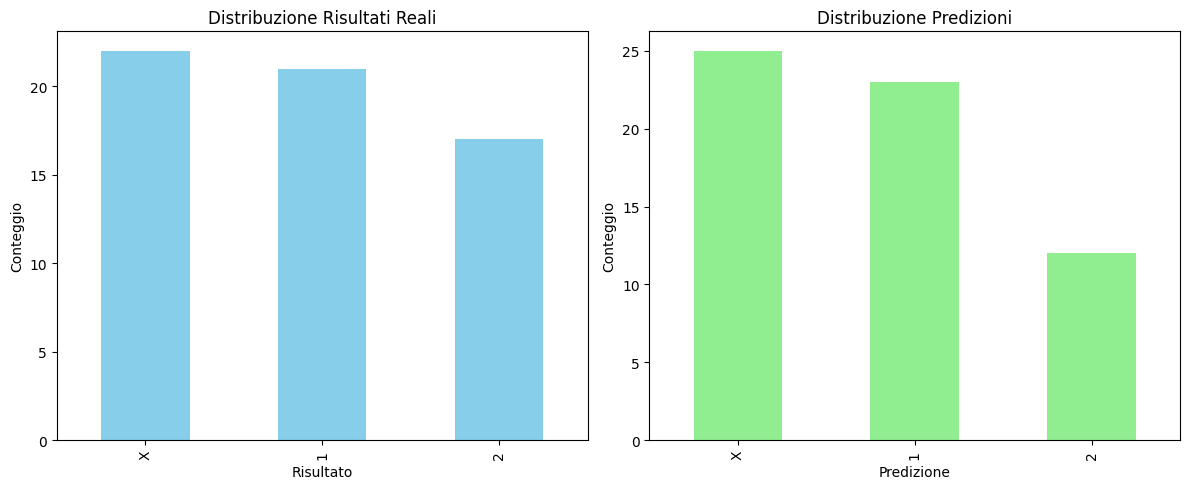

ModuleNotFoundError: No module named 'seaborn'

In [35]:
# Confrontiamo la distribuzione delle predizioni con i risultati reali
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
predictions_df['Risultato'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione Risultati Reali')
plt.xlabel('Risultato')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
predictions_df['Prediction'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribuzione Predizioni')
plt.xlabel('Predizione')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()

# Matrice di confusione
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions_df['Risultato'], predictions_df['Prediction'], labels=['1', 'X', '2'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title(f'Matrice di Confusione (Threshold = {best_threshold:.1f})')
plt.show()

## Confronto con altri modelli

Il nostro modello basato sulle medie dei gol è semplice ma efficace. La sua accuratezza dipende dal threshold scelto, che determina quanto deve essere grande la differenza tra i gol attesi delle due squadre per prevedere una vittoria invece di un pareggio.

Questo approccio rappresenta bene il fattore casa/trasferta, poiché consideriamo separatamente le prestazioni delle squadre nei due contesti.

Il modello potrebbe essere migliorato considerando anche:
- La forma recente delle squadre (ultimi 5 match)
- Gli scontri diretti della stagione
- La posizione in classifica
- L'importanza della partita (obiettivi di classifica)